In [26]:
import tensorflow as tf
import os 
import zipfile

DESIRED_ACCURACY=0.999

!wget --no-check-certificate \
    "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip" \
    -O "/tmp/happy-or-sad.zip"

zip_ref = zipfile.ZipFile("/tmp/happy-or-sad.zip", 'r')
zip_ref.extractall("/tmp/h-or-s")
zip_ref.close()

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>DESIRED_ACCURACY):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

--2020-11-22 01:55:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.12.240, 142.250.31.128, 172.217.164.176, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.12.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2670333 (2.5M) [application/zip]
Saving to: ‘/tmp/happy-or-sad.zip’

/tmp/happy-or-sad.z 100%[===================>]   2.55M  --.-KB/s    in 0.01s   

2020-11-22 01:55:18 (186 MB/s) - ‘/tmp/happy-or-sad.zip’ saved [2670333/2670333]



In [6]:
#ImageGenerator will label the images appropriately through the directories
# Directory with our training horse pictures
train_happy_dir = os.path.join('/tmp/h-or-s/happy')

# Directory with our training human pictures
train_sad_dir = os.path.join('/tmp/h-or-s/sad')

In [7]:
train_happy_names=os.listdir(train_happy_dir)

In [8]:
print(train_happy_names[:10])

['happy2-13.png', 'happy2-12.png', 'happy1-14.png', 'happy1-01.png', 'happy2-18.png', 'happy1-16.png', 'happy1-03.png', 'happy2-00.png', 'happy2-11.png', 'happy1-08.png']


In [9]:
train_sad_names=os.listdir(train_sad_dir)
print(train_sad_names[:10])

['sad2-00.png', 'sad1-11.png', 'sad1-17.png', 'sad1-19.png', 'sad1-12.png', 'sad1-00.png', 'sad1-13.png', 'sad2-07.png', 'sad2-01.png', 'sad1-16.png']


In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [16]:
nrows = 4
ncols = 4
pic_index = 0

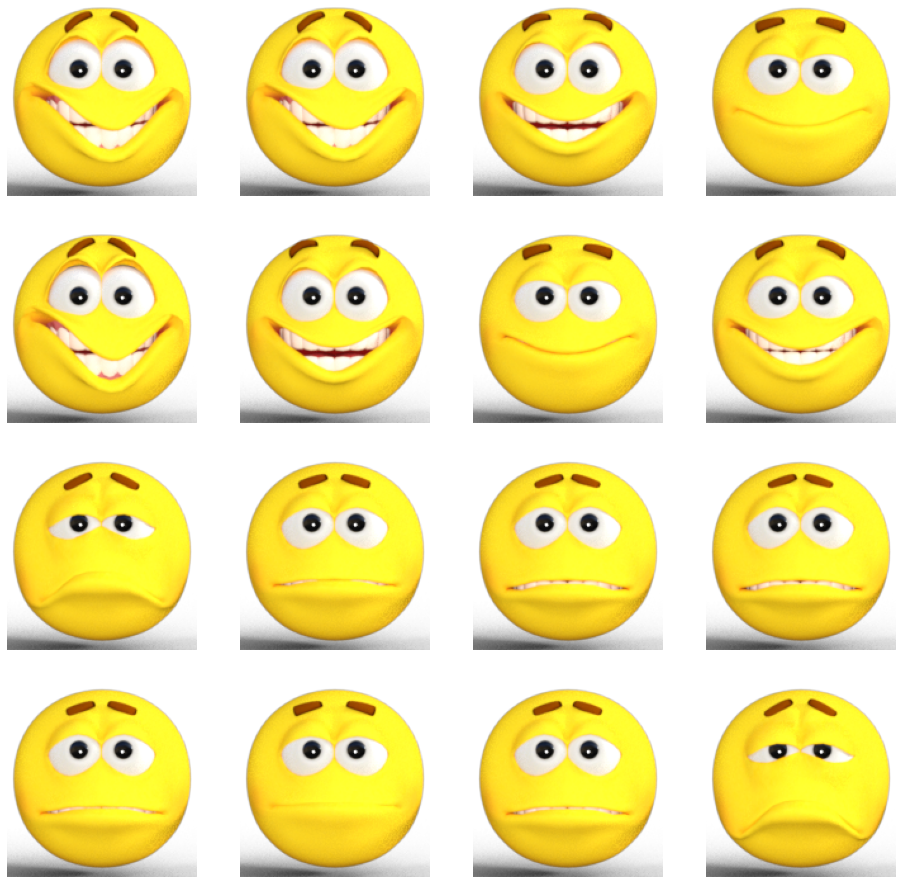

In [17]:
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_happy_pix = [os.path.join(train_happy_dir, fname) 
                for fname in train_happy_names[pic_index-8:pic_index]]
next_sad_pix = [os.path.join(train_sad_dir, fname) 
                for fname in train_sad_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_happy_pix+next_sad_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') 

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        3

In [20]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/tmp/h-or-s/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 80 images belonging to 2 classes.


In [27]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=15,
      verbose=1,
      callbacks=[callbacks])

Epoch 1/15
8/8 [==============================] - 0s 6ms/step - loss: 0.6690 - accuracy: 0.6250
Epoch 2/15
8/8 [==============================] - 0s 5ms/step - loss: 0.9857 - accuracy: 0.6250
Epoch 3/15
8/8 [==============================] - 0s 5ms/step - loss: 0.7325 - accuracy: 0.5000
Epoch 4/15
8/8 [==============================] - 0s 5ms/step - loss: 0.7036 - accuracy: 0.6250
Epoch 5/15
8/8 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.5000
Epoch 6/15
8/8 [==============================] - 0s 5ms/step - loss: 0.5992 - accuracy: 0.6250
Epoch 7/15
8/8 [==============================] - 0s 5ms/step - loss: 0.9354 - accuracy: 0.3750
Epoch 8/15
8/8 [==============================] - 0s 5ms/step - loss: 0.5177 - accuracy: 0.8750
Epoch 9/15
8/8 [==============================] - 0s 6ms/step - loss: 0.7980 - accuracy: 0.8750
Epoch 10/15
8/8 [==============================] - 0s 6ms/step - loss: 0.8098 - accuracy: 0.6250
Epoch 11/15
1/8 [==>...................